# Projeto Final Redes Neurais

<b> Alunos: </b> João Otávio de Ávila Nascimento, Emelyn Alves e Kayllanny Lara da Silva Oliveira
\
<b> Professor: </b> Daniel Cassar

Inicialmente, realizamos a importação de todas as bibliotecas necessárias para o funcionamento do código, garantindo que todas as dependências e ferramentas essenciais estejam disponíveis para execução correta e eficiente do programa.

In [3]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
import lightning as L

ModuleNotFoundError: No module named 'lightning'

Após as importações, carregamos nosso dataset, que é um conjunto de dados sintéticos do setor agrícola. Ele relaciona o rendimento em kg por hectare com a qualidade do solo, a variedade das sementes, a quantidade de fertilizante por hectare em kg, a quantidade de dias de sol, de precipitação em mm e os horários de irrigação. Esses dados são importantes, pois permitem prever a colheita de acordo com as condições e identificar as condições ideais para o crescimento das lavouras.

In [2]:
features = ['Soil_Quality', 'Seed_Variety', 'Fertilizer_Amount_kg_per_hectare', 'Sunny_Days', 'Rainfall_mm', 'Irrigation_Schedule']
target = ['Yield_kg_per_hectare']

df_teste = pd.read_csv("agricultural_yield_test.csv")
df_treino = pd.read_csv("agricultural_yield_train.csv")

df_teste = df_teste.reindex(features + target, axis=1)
df_teste = df_teste.dropna()

df_treino = df_treino.reindex(features + target, axis=1)
df_treino = df_treino.dropna()

Aqui, separamos os atributos dos alvos. Como os dados de treino e teste já vieram separados, apenas os carregamos em suas respectivas variáveis, removemos os valores ausentes e imprimimos as variáveis a seguir.

In [3]:
df_teste

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,93.304721,0,132.522218,96.670922,602.386237,3,278.986563
1,83.674653,1,57.283997,99.007556,466.518251,8,836.434840
2,65.963033,1,227.895479,104.844272,510.320495,4,785.881787
3,78.692834,1,176.314126,90.136191,354.350914,5,807.884526
4,72.415684,1,160.070418,101.221668,443.993788,10,1064.542374
...,...,...,...,...,...,...,...
3995,95.094714,1,124.108262,98.970659,496.705800,5,802.209345
3996,53.256984,0,100.310322,111.448947,667.056391,8,509.646540
3997,94.145522,1,196.473704,110.003474,458.241408,3,776.013634
3998,61.452120,1,80.618357,97.815517,778.652540,4,502.319484


In [4]:
df_treino

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,96.415657,1,147.853040,94.593926,444.267569,3,683.759119
1,92.352626,0,281.565396,90.504644,517.585491,7,678.714861
2,63.714785,1,137.864940,97.329340,420.310945,8,934.691975
3,90.084256,1,100.946659,113.404828,547.817646,7,905.842541
4,81.600341,1,223.088908,83.048176,434.726333,6,897.584665
...,...,...,...,...,...,...,...
15995,77.053550,1,154.189768,103.115855,319.915079,7,956.781949
15996,99.795631,1,282.295839,123.598354,647.292136,4,879.682714
15997,67.478487,1,120.017122,102.308627,514.372747,8,932.829561
15998,85.176890,1,247.847389,114.956634,695.035801,6,889.738438


Nesta célula, foi gerada uma matriz de correlação para observar a relação entre as colunas do dataset

In [ ]:
correlation_matrix = df_treino.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.show()

Aqui estão os parâmetros da validação que serão utilizados posteriormente no código.

In [6]:
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 61455

Agora, finalmente, separamos os dados do dataset em alvo (target) e atributos.

In [7]:
X_teste = df_teste.reindex(features, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

Agora, dividimos o conjunto de treinamento em subconjuntos de treinamento e validação usando a técnica de divisão (split).

In [8]:
indices = df_treino.index
print(indices, len(indices))
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_VALIDACAO, random_state=SEMENTE_ALEATORIA
)

print(indices_treino, len(indices_treino))
print()
print(indices_val, len(indices_val))

df_val = df_treino.loc[indices_val]
df_treino = df_treino.loc[indices_treino]


X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

X_val = df_val.reindex(features, axis=1).values
y_val = df_val.reindex(target, axis=1).values

RangeIndex(start=0, stop=16000, step=1) 16000
Index([ 2519, 11035,  3934, 14982,  4078, 12245, 12217,  9147, 11629,  3768,
       ...
        6255,  7971, 13014,  6321, 12691,  2256, 10672,  6652, 11166, 13937],
      dtype='int64', length=14400) 14400

Index([ 8987,  4178,  4313,  1666,  6784, 12065, 10246,  8625,  9889,  6176,
       ...
        4452, 12565, 12620, 13756, 14945,    97,  8368, 10148, 12993,  5542],
      dtype='int64', length=1600) 1600


Nas células de código abaixo, realizamos a normalização e a preparação dos dados para treinar e testar a rede neural.

In [9]:
x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste)

In [10]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [11]:
X_teste

tensor([[0.9331, 0.0000, 0.4418, 0.6788, 0.6905, 0.2000],
        [0.8368, 1.0000, 0.1910, 0.6952, 0.5348, 0.5333],
        [0.6596, 1.0000, 0.7597, 0.7362, 0.5850, 0.2667],
        ...,
        [0.9415, 1.0000, 0.6549, 0.7724, 0.5253, 0.2000],
        [0.6145, 1.0000, 0.2687, 0.6868, 0.8926, 0.2667],
        [0.5520, 0.0000, 0.4083, 0.6341, 0.6683, 0.2667]])

In [12]:
y_teste

tensor([[0.2014],
        [0.6039],
        [0.5674],
        ...,
        [0.5603],
        [0.3627],
        [0.1856]])

In [13]:
X_treino

tensor([[0.9795, 0.0000, 0.7640, 0.7867, 0.4237, 0.2000],
        [0.9797, 0.0000, 0.9775, 0.5857, 0.6576, 0.2667],
        [0.9986, 1.0000, 0.4590, 0.6481, 0.5381, 0.1333],
        ...,
        [0.6414, 1.0000, 0.9437, 0.7126, 0.5219, 0.3333],
        [0.6388, 1.0000, 0.4695, 0.6392, 0.3804, 0.2667],
        [0.9902, 1.0000, 0.5284, 0.7755, 0.6688, 0.3333]])

In [14]:
y_treino

tensor([[0.3213],
        [0.3385],
        [0.4438],
        ...,
        [0.6514],
        [0.4705],
        [0.5933]])

In [15]:
X_val

tensor([[0.6182, 1.0000, 0.3226, 0.7208, 0.6738, 0.5333],
        [0.9165, 0.0000, 0.1888, 0.6953, 0.4263, 0.0667],
        [0.6729, 1.0000, 0.5926, 0.7751, 0.6263, 0.2667],
        ...,
        [0.7481, 1.0000, 0.2723, 0.6990, 0.4905, 0.4667],
        [0.5995, 1.0000, 0.7954, 0.6793, 0.6092, 0.5333],
        [0.5068, 1.0000, 0.8737, 0.7273, 0.5378, 0.5333]])

In [16]:
y_val

tensor([[0.6336],
        [0.1526],
        [0.5981],
        ...,
        [0.5879],
        [0.7066],
        [0.6803]])

## Treinando a rede com uma arquitetura aleatória

Esta célula é o passo inicial para criarmos e treinarmos nosso modelo. Utiliza a classe mãe, o DataModule do Lightning, que encapsula diversas informações necessárias para preparar nossos dados e futuramente usar o Lightning no treinamento.

In [29]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 8,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

Para verificar se os dados estavam devidamente tratados e se funcionariam em nossa MLP, criamos uma MLP de teste com arquitetura aleatória

In [18]:
class MLP_teste(L.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(),
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.Sigmoid(),
            nn.Linear(neuronios_c2, num_targets),
        )  
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

Aqui, definimos o número de épocas e criamos o treinador, que executará o treinamento pela quantidade de épocas especificada

In [19]:
NUM_EPOCAS = 20

treinador = L.Trainer(max_epochs=NUM_EPOCAS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/joao23022/anaconda3/envs/redes/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Precisamos também criar uma instância da classe `DataModule` que definimos acima.



In [20]:
dm = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

Antes de treinar, precisamos também criar uma instância da rede neural.



In [21]:
num_dados_de_entrada = 6
num_dados_de_saida = 1
neuronios_c1 = random.randint(1, 120)
neuronios_c2 = random.randint(1, 120)

mlp_teste = MLP_teste(
    num_dados_de_entrada, neuronios_c1, neuronios_c2, num_dados_de_saida
)

Finalmente, temos tudo que precisamos. Podemos rodar o método `fit` do nosso treinador na nossa instância da rede neural, fornecendo também uma instância do `DataModule` como argumento.



In [22]:
treinador.fit(mlp_teste, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 463   
---------------------------------------
463       Trainable params
0         Non-trainable params
463       Total params
0.002     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 57/57 [00:00<00:00, 205.81it/s, v_num=319, loss=0.0302]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 57/57 [00:00<00:00, 339.25it/s, v_num=319, loss=0.0172, val_loss=0.0312]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 57/57 [00:00<00:00, 344.14it/s, v_num=319, loss=0.0166, val_loss=0.0218]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 57/57 [00:00<00:00, 337.25it/s, v_num=319, loss=0.0165, val_loss=0.0217]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 57/57 [00:00<00:00, 337.46it/s, v_num=319, loss=0.0165, val_loss=0.0217]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 57/57 [00:00<00:00, 300.46it/s, v_num=319, loss=0.0165, val_loss=0.0217]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 57/57 [00:00<00:00, 337.86it/s, v_num=319, loss=0.0165, val_loss=0.0217]
Validation: |          | 0/? [00:00<?, ?it/s]
Ep

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 57/57 [00:00<00:00, 295.98it/s, v_num=319, loss=0.0164, val_loss=0.0216]


O gráfico abaixo mostra a curva de aprendizado, comparando o treino com a validação.

Text(0, 0.5, 'Loss')

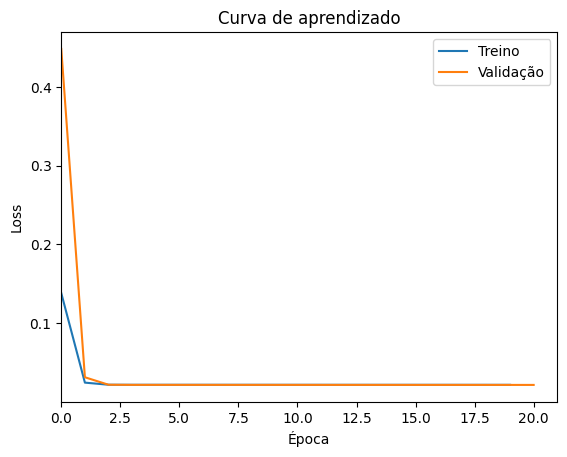

In [23]:
figura, eixo = plt.subplots()

ca_treino = mlp_teste.curva_aprendizado_treino
ca_val = mlp_teste.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

## Testando a rede com a arquitetura aleatória

Antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.



In [24]:
mlp_teste.eval()

MLP_teste(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=61, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=61, out_features=1, bias=True)
  )
)

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [25]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = mlp_teste(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

200.79882150446042


/home/joao23022/anaconda3/envs/redes/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Após todos esses passos, podemos observar que os dados estão adequados e podemos partir para o nosso modelo real. Além disso, é possível ver que o RMSD desse modelo de teste ficou alto, pois ninguém deseja um RMSD de 200.

## Treinando diferentes MLPs

Hiperparâmetros: neurônios (cada camada), camadas e dropout.

Aqui criamos o Nosso modelo de rede será treinado com diferentes arquiteturas, variando os hiperparâmetros listados acima.

In [26]:
class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, num_targets, neuronios, dropouts
    ):
        super().__init__()    
        
        camadas = []   
        
        neuronios = [num_dados_entrada]+neuronios
    
        for k in range(len(neuronios)-1):
            camadas.append(nn.Linear(neuronios[k], neuronios[k+1]))
            camadas.append(nn.ReLU())
            camadas.append(nn.Dropout(dropouts[k]))
        
        camadas.append(nn.Linear(neuronios[-1], num_targets))
        
        self.camadas = nn.Sequential(*camadas) 
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

A função objective é responsável por explorar as diferentes possíveis arquiteturas, variando esses três hiperparâmetros e utilizando o Optuna para nos ajudar a encontrar o melhor modelo dentre as arquiteturas testadas.

In [27]:
def objective(trial: optuna.trial.Trial) -> float:
    
    MAX_EPOCHS = 100

    # We optimize the number of layers, hidden units in each layer and dropouts.
    num_dados_entrada = 6
    num_targets = 1
    
    neuronios = []   
    dropouts = []
    
    n_camadas = trial.suggest_int("n_layers", 1, 5)
        
    for i in range(n_camadas):
        neuronio = trial.suggest_int(f'n_units{i}', 4, 120)
        neuronios.append(neuronio)
        dropout = trial.suggest_float("dropout", 0.2, 0.5)
        dropouts.append(dropout)
        
    print(neuronios, dropouts)

    model = MLP(num_dados_entrada, num_targets, neuronios, dropouts)
    datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)
    
    early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
    treinador= L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[early_stop_callback], enable_progress_bar=False) 
    
    treinador.fit(model, datamodule=datamodule)

    return treinador.callback_metrics["val_loss"].item()

Nesta célula, utilizamos a função e a classe definidas anteriormente para testar diferentes arquiteturas, totalizando 150.

In [ ]:
N_TRIALS = 150
num_dados_entrada = 6
num_targets = 1

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=N_TRIALS)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

Nesta célula, criamos o DataModule modelo e selecionamos os parâmetros com melhor desempenho no estudo de arquiteturas. A partir disso, criamos nosso modelo.

In [39]:
# Criar DataModule
datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)
     
camadas = [key for key in trial.params.keys() if key.startswith('n_units')]
    
neuronios = []
    
for k in camadas:
    neuronios.append(trial.params[f'{k}'])
    
dropouts = [trial.params.get('dropout')] * len(camadas)


# Criar o modelo com os parâmetros do melhor teste
melhor_modelo = MLP(num_dados_entrada, num_targets, neuronios, dropouts)

melhor_modelo.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=106, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.21526056650628722, inplace=False)
    (3): Linear(in_features=106, out_features=1, bias=True)
  )
)

Nesta etapa, realizamos o treinamento do modelo. Uma definição importante é que o treinamento irá ocorrer até que o número de épocas seja atingido ou até que ocorra uma piora em três épocas consecutivas.

In [40]:
# Treinar o modelo com o Trainer
MAX_EPOCHS = 100

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
treinador= L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[early_stop_callback], enable_progress_bar=False) 
treinador.fit(melhor_modelo, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 849   
---------------------------------------
849       Trainable params
0         Non-trainable params
849       Total params
0.003     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=100` reached.


O gráfico abaixo apresenta a curva de aprendizado, comparando o desempenho do treino com a validação, agora do nosso modelo real.

Text(0, 0.5, 'Loss')

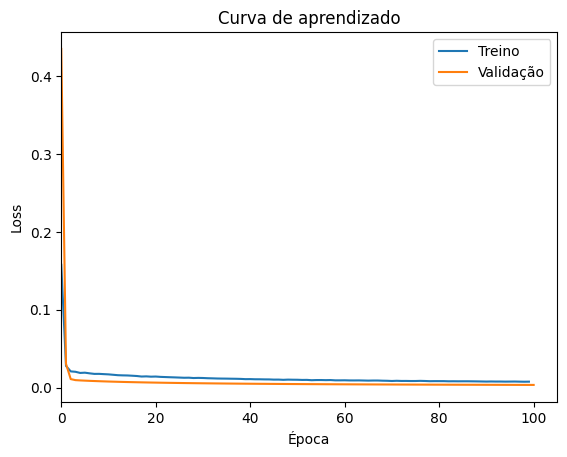

In [47]:
# Plot treino e validação
    
figura, eixo = plt.subplots()

ca_treino_melhor_modelo = melhor_modelo.curva_aprendizado_treino
ca_val_melhor_modelo = melhor_modelo.curva_aprendizado_val

eixo.plot(ca_treino_melhor_modelo, label="Treino")
eixo.plot(ca_val_melhor_modelo, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

## Testando o melhor modelo encontrado

Antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.



In [48]:
melhor_modelo.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=106, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.21526056650628722, inplace=False)
    (3): Linear(in_features=106, out_features=1, bias=True)
  )
)

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [49]:
datamodule.setup("test")

with torch.no_grad():
    X_true = datamodule.X_teste

    y_true = datamodule.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = melhor_modelo(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

80.65721991248533


/home/joao23022/anaconda3/envs/redes/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Agora que concluímos todo o treinamento, podemos perceber que houve uma melhoria significativa no RMSE do primeiro modelo de teste para este, que passou pelo processo de otimização. Antes, o RMSE era de 200 e agora diminuiu para 80. Embora o modelo não seja perfeito, é razoável. Para melhorar ainda mais o RMSE, seria necessário testar mais arquiteturas ou variar outros parâmetros.